# **Sentiment Analysis of Social Media Posts**

This notebook demonstrates how to perform sentiment analysis on social media text data using both traditional machine learning and deep learning approaches. It includes preprocessing, feature extraction, model training (Naive Bayes, SVM), and an LSTM-based neural network for deeper understanding of textual sentiment.

**1. Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


All essential packages are imported for:

*   Data handling: pandas, numpy

*   Text processing: re, nltk
*   Modeling: scikit-learn, TensorFlow, Keras


*   Preprocessing: tokenizing, padding sequences










In [3]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load stopwords and lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**2. Load and Clean Data**

We load a CSV dataset containing social media posts and their corresponding sentiment labels. Then we clean the text by removing noise such as links, hashtags, and non-letter characters.

In [4]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('Combined Data.csv')
df = df.dropna(subset=['statement'])


Saving Combined Data.csv to Combined Data.csv




*   Uploads a CSV with statement (text) and status (label).
*   Drops rows without text.



**Cleaning Function:**

In [5]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.IGNORECASE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    return text



*   Removes links, hashtags, mentions.

*   Keeps only alphabets.
*   Converts to lowercase.




**Preprocessing Function:**

In [6]:
def preprocess(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)



*   Applies clean_text

*   Tokenizes text

*   Lemmatizes each word



*   Removes stopwords


*   Joins cleaned tokens back to string



**Apply preprocessing:**

In [7]:
df['clean_text'] = df['statement'].apply(preprocess)

**3. Encode Sentiment Labels**

Convert categorical sentiment labels (e.g., positive, negative, neutral) into numerical form for model training.

In [8]:
df['label'] = df['status'].astype('category').cat.codes
num_classes = df['label'].nunique()
label_mapping = dict(enumerate(df['status'].astype('category').cat.categories))
print("Label Mapping:", label_mapping)

Label Mapping: {0: 'Anxiety', 1: 'Bipolar', 2: 'Depression', 3: 'Normal', 4: 'Personality disorder', 5: 'Stress', 6: 'Suicidal'}




*   Converts text labels like Anxiety → 0, Bipolar → 1, etc.
*   Stores the mapping of labels to use later for reports.



**4. Split Dataset**

Split the cleaned data into training and testing sets for model evaluation.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])



*   80/20 split
*   stratify=df['label'] ensures class balance in train/test



**5. Text Vectorization with TF-IDF**

Use TF-IDF to convert raw text into numerical features for traditional models.

In [10]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)



*   Creates numerical features by measuring word importance
*   Keeps top 5000 words



**6. Model 1: Naive Bayes**

Train and evaluate a Multinomial Naive Bayes model on the TF-IDF features.

In [11]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_predictions = nb_model.predict(X_test_tfidf)

print("\nNaive Bayes Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:\n", classification_report(y_test, nb_predictions, target_names=[label_mapping[i] for i in range(num_classes)]))


Naive Bayes Model Evaluation:
Accuracy: 0.6703046407895985
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.79      0.62      0.69       768
             Bipolar       0.87      0.50      0.64       556
          Depression       0.52      0.81      0.63      3081
              Normal       0.83      0.83      0.83      3269
Personality disorder       1.00      0.11      0.19       215
              Stress       0.76      0.09      0.16       517
            Suicidal       0.69      0.50      0.58      2131

            accuracy                           0.67     10537
           macro avg       0.78      0.49      0.53     10537
        weighted avg       0.71      0.67      0.65     10537





*   Suitable for word-count features like TF-IDF
*   Fast and baseline-strong for text classification


**Output Accuracy**: 67%





**7. Model 2: Support Vector Machine (SVM)**

Train and evaluate a Support Vector Machine with a linear kernel.

In [12]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
svm_predictions = svm_model.predict(X_test_tfidf)

print("\nSVM Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("Classification Report:\n", classification_report(y_test, svm_predictions, target_names=[label_mapping[i] for i in range(num_classes)]))


SVM Model Evaluation:
Accuracy: 0.7647337951978742
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.79      0.78      0.79       768
             Bipolar       0.85      0.73      0.79       556
          Depression       0.70      0.73      0.71      3081
              Normal       0.86      0.94      0.90      3269
Personality disorder       0.79      0.56      0.66       215
              Stress       0.66      0.47      0.55       517
            Suicidal       0.69      0.63      0.66      2131

            accuracy                           0.76     10537
           macro avg       0.76      0.69      0.72     10537
        weighted avg       0.76      0.76      0.76     10537





*   Uses hyperplanes to separate text classes
*   Performs better than Naive Bayes in general for text data

**Output Accuracy**: ~76%


*   Significantly better F1 for most classes
*   Still weak on underrepresented classes





**8. Model 3: LSTM Neural Network**

We use tokenization and padding to prepare the text data for a deep learning model.

In [13]:
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')



*   Converts words to indices (max 10k unique tokens)
*   Pads all sequences to 100 tokens



**Build the LSTM model:**


In [14]:
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Dense

# Defining the model
lstm_model = Sequential()
lstm_model.add(Input(shape=(maxlen,)))
lstm_model.add(Embedding(input_dim=10000, output_dim=128))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,863 (5.07 MB)

 Trainable params: 1,329,863 (5.07 MB)

 Non-trainable params: 0 (0.00 B)



*   Embedding Layer: Converts indices to dense vectors
*   LSTM Layer: Captures sequential meaning
*   Dense Layer: Outputs class probabilities with softmax








**9. Evaluate LSTM Performance**

Predict and print metrics for the LSTM model.

In [15]:
# Train the LSTM model
history = lstm_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.2)

# Predict probabilities on the test set
lstm_predictions_probs = lstm_model.predict(X_test_pad)
# Convert probabilities to class labels
lstm_predictions = np.argmax(lstm_predictions_probs, axis=1)

# Evaluation
print("\nLSTM Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, lstm_predictions))
print("Classification Report:\n", classification_report(y_test, lstm_predictions, target_names=[label_mapping[i] for i in range(num_classes)]))

Epoch 1/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 105s 190ms/step - accuracy: 0.4018 - loss: 1.5549 - val_accuracy: 0.5487 - val_loss: 1.2618
Epoch 2/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 145s 197ms/step - accuracy: 0.5412 - loss: 1.2477 - val_accuracy: 0.5950 - val_loss: 1.0405
Epoch 3/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 138s 189ms/step - accuracy: 0.6026 - loss: 0.9672 - val_accuracy: 0.6322 - val_loss: 0.8518
Epoch 4/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 141s 188ms/step - accuracy: 0.6648 - loss: 0.7982 - val_accuracy: 0.7054 - val_loss: 0.7768
Epoch 5/5
527/527 ━━━━━━━━━━━━━━━━━━━━ 99s 188ms/step - accuracy: 0.7436 - loss: 0.6749 - val_accuracy: 0.7335 - val_loss: 0.6921
330/330 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step

LSTM Model Evaluation:
Accuracy: 0.7210781057226915
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.69      0.83      0.75       768
             Bipolar       0.64      0.74      0.69       556
          Depression       0.68      0.6



*   Accuracy improved over time:   

  *   Epoch 1: 40%
  *   Epoch 5: ~74% train, ~73% val


This shows the model is learning well without overfitting.



### **LSTM Model Evaluation :**
**Accuracy:** ~72%

F1-score varies:

*   Normal: 90%
*   Depression: 65%



## **1. Naive Bayes Confusion Matrix**

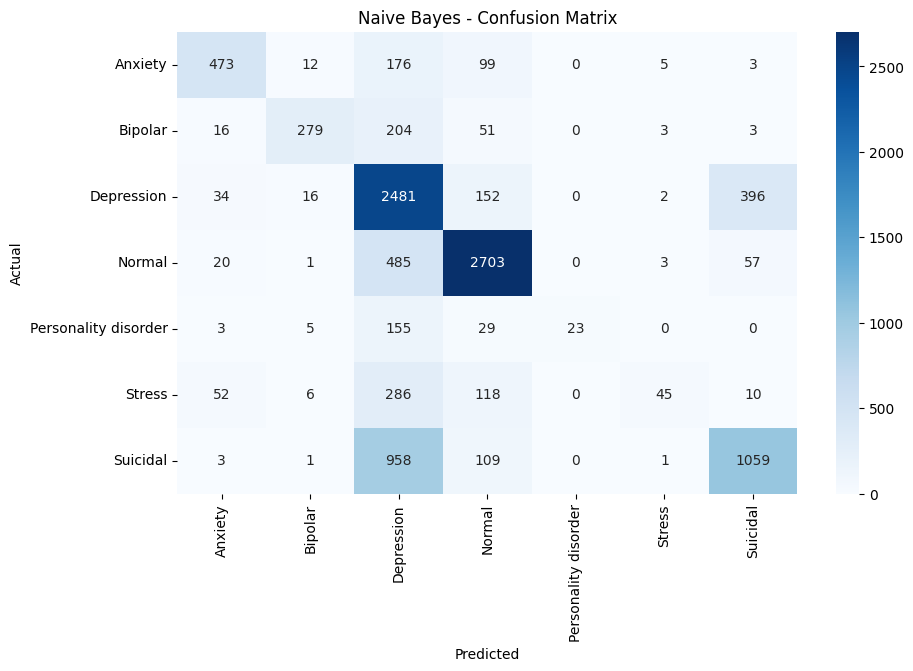

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use integer label values directly
nb_cm = confusion_matrix(y_test, nb_preds)

# Extract class names using the original label mapping
labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## **2. SVM Confusion Matrix**

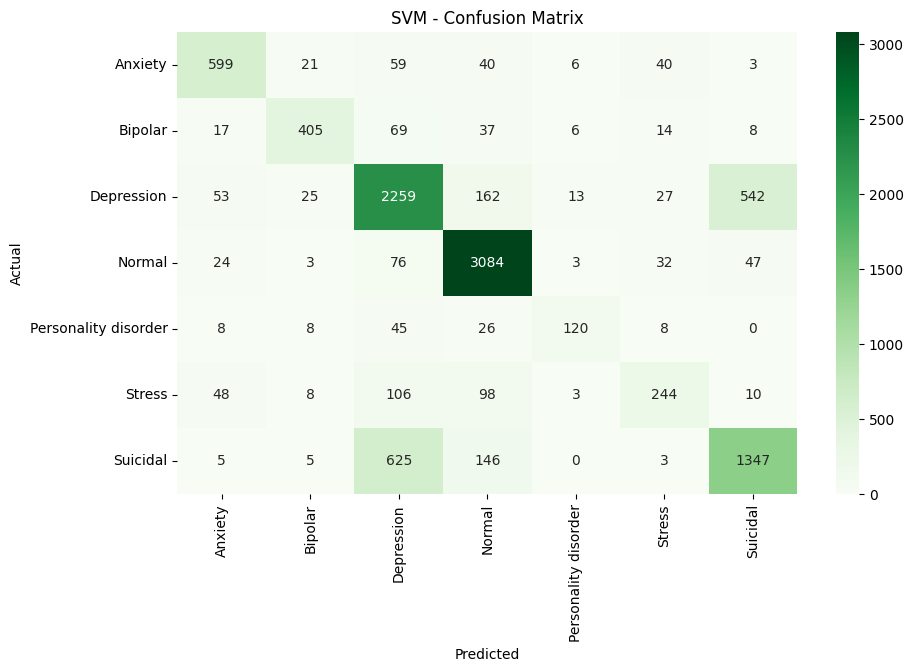

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure svm_preds exists
svm_preds = svm_model.predict(X_test_tfidf)

# Compute confusion matrix
svm_cm = confusion_matrix(y_test, svm_preds)

# Extract class labels
class_labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## **3. LSTM Confusion Matrix**

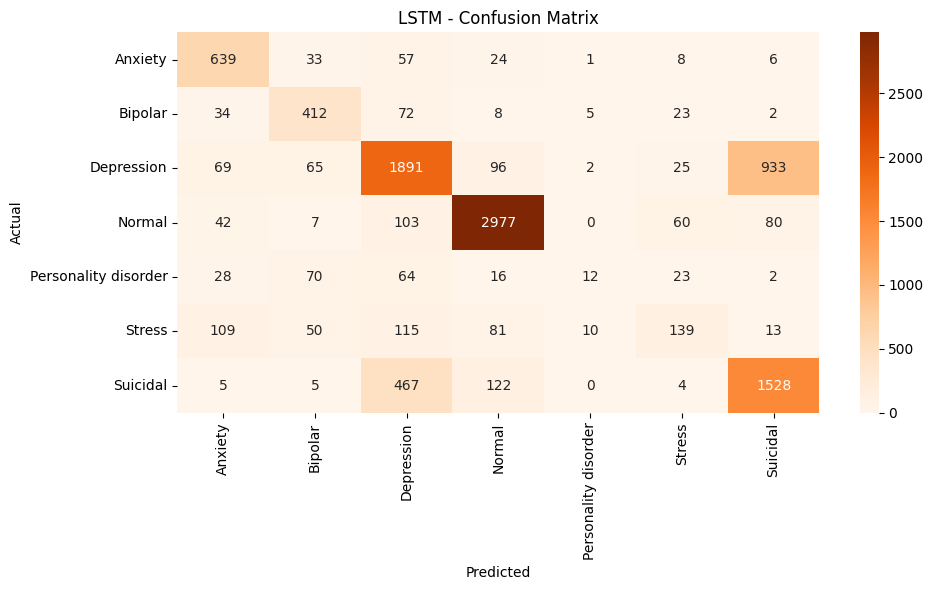

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get class labels from label_mapping
class_labels = [label_mapping[i] for i in sorted(label_mapping.keys())]

# Compute confusion matrix
lstm_cm = confusion_matrix(y_test, lstm_predictions)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("LSTM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## **How many words are in each sample after preprocessing ?**

In [24]:
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))
print("Total posts:", len(df))
print("Average words per post:", df['word_count'].mean())
print("Max words in a post:", df['word_count'].max())
print("Min words in a post:", df['word_count'].min())
X_train_word_counts = X_train.apply(lambda x: len(x.split()))
X_test_word_counts = X_test.apply(lambda x: len(x.split()))

print("Train - Avg words:", X_train_word_counts.mean())
print("Test - Avg words:", X_test_word_counts.mean())


Total posts: 52681
Average words per post: 51.515024392095825
Max words in a post: 3780
Min words in a post: 0
Train - Avg words: 51.636460706150345
Test - Avg words: 51.02932523488659


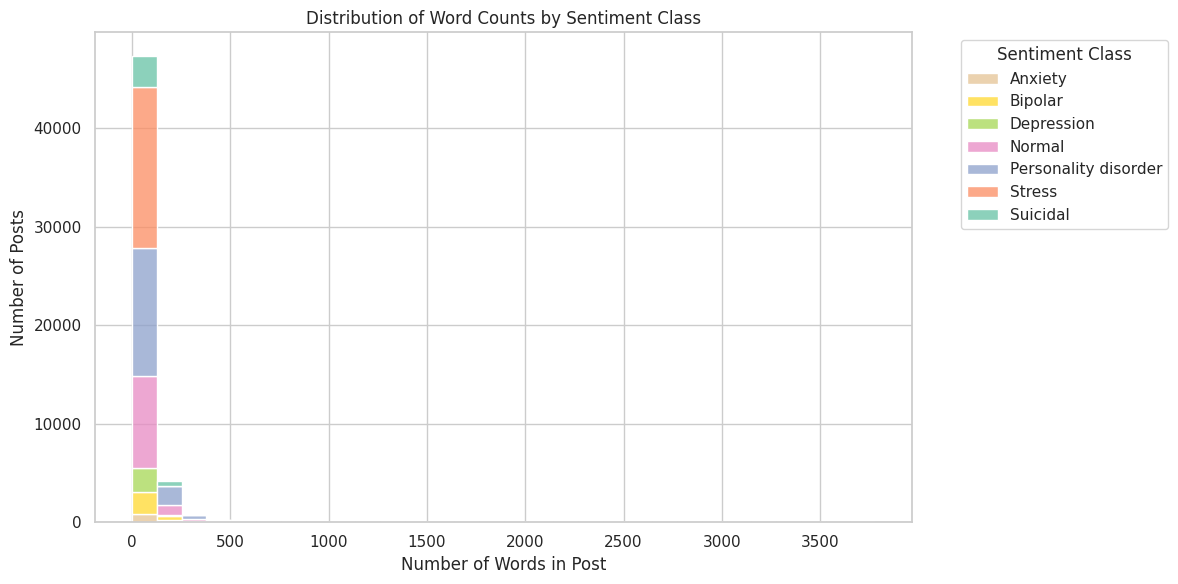

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column with word count
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# Map numeric labels back to original sentiment labels
df['sentiment'] = df['label'].map(label_mapping)

# Custom color palette for consistent legend
custom_palette = sns.color_palette("Set2", n_colors=len(label_mapping))

# Set plot style
sns.set(style="whitegrid")

# Plot: Word Count Histogram by Sentiment Class
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x='word_count',
    hue='sentiment',
    multiple='stack',
    bins=30,
    palette=custom_palette
)

plt.title('Distribution of Word Counts by Sentiment Class')
plt.xlabel('Number of Words in Post')
plt.ylabel('Number of Posts')
plt.legend(title='Sentiment Class', labels=label_mapping.values(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## **Boxplot: Word Count by Sentiment Class**

<ipython-input-26-68ea156291fe>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='sentiment', y='word_count', palette='Set3')


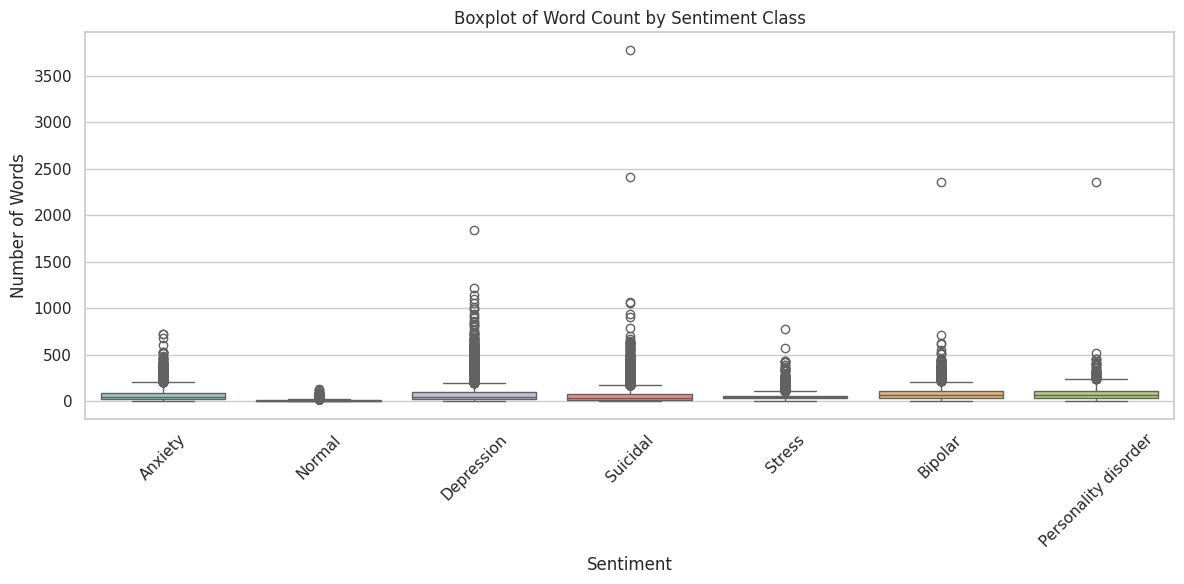

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='sentiment', y='word_count', palette='Set3')
plt.title('Boxplot of Word Count by Sentiment Class')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-27-af662e735f2b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='sentiment', y='word_count', palette='Set2', inner='quartile')


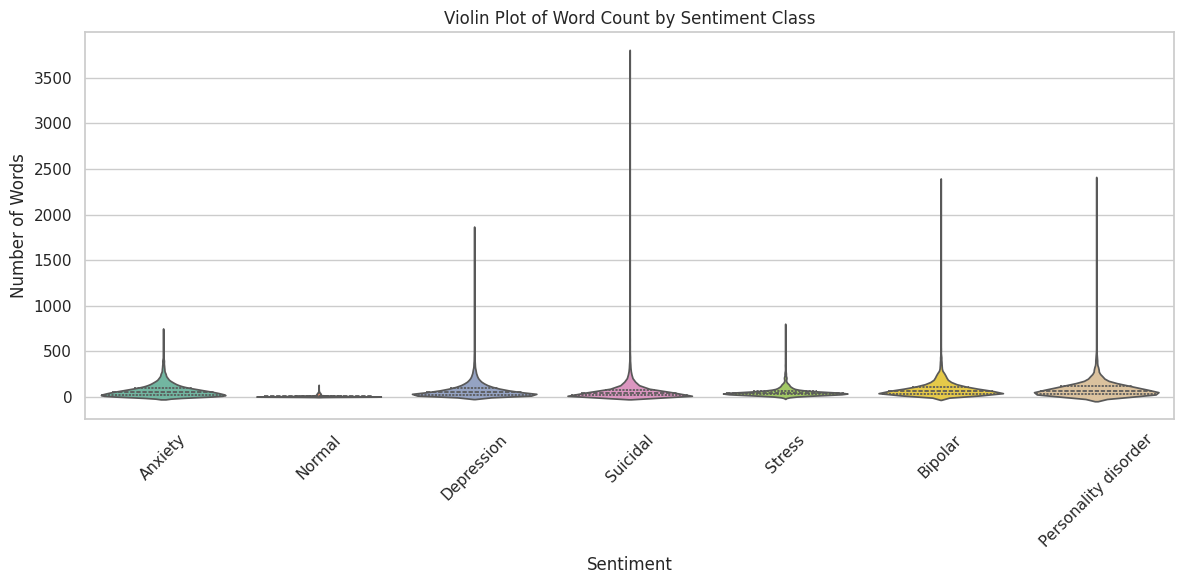

In [27]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='sentiment', y='word_count', palette='Set2', inner='quartile')
plt.title('Violin Plot of Word Count by Sentiment Class')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Comparison Summary**

| Model       | Accuracy | Strengths                  | Weaknesses                   |
|-------------|----------|----------------------------|------------------------------|
| Naive Bayes | 67%      | Fast, baseline             | Weak on underrepresented classes |
| SVM         | 76%      | Strong all-around          | Still weak on rare labels    |
| LSTM        | 70%      | Learns context better      | Needs more data for rare classes |

## **Summary :**

This project shows how to build a sentiment analysis system for social media posts using:


*   **Naive Bayes** and **SVM** with TF-IDF features.
*   **LSTM neural networks** using word embeddings and sequence modeling.






These models allow detection of sentiment in short, noisy, real-world texts. Future enhancements could include using pre-trained embeddings (like GloVe or FastText) or advanced architectures like BERT for improved accuracy and context understanding.